# Notebook to compute intrinsic alignments of galaxies directly from the data

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value
from astropy import units as u

import treecorr

from scipy.ndimage import gaussian_filter

### Cosmological parameters

In [45]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3) ; h=0.7

### Function required for further work

In [46]:
# Computing complex ellipticity
def e_complex(a,b,r):
    abs_e = (1-(b/a)) / (1+(b/a))
    e1 = abs_e*np.cos(2*r)
    e2 = abs_e*np.sin(2*r)
    return e1, e2

### Downloading the data for analysis

#### About the data : 

- Observed ellipticity : $e = e_1+ie_2$

- Inverse variance weight for each galaxy : 

### $w = \frac{1}{2\sigma_{SN}^2+\sigma_{\epsilon_1}^2+\sigma_{\epsilon_2}^2}$

with $\sigma_{SN}$ is the galaxy shape noise ; $\sigma_{e_1}$ and $\sigma_{e_2}$ are the variance of the ellipticity of the galaxy (https://arxiv.org/pdf/2412.01790)

#### UNIONS-CMASS data (see the matched catalogues of galaxies and the matching procedure in the file "data" in the main branch)

In [13]:
# Downloading UNIONS-CMASS to have the information about the shapes of the galaxies
unions_cmass_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/UNIONS-SDSS/unions_cmass_cross.fits')

names = [name for name in unions_cmass_table.colnames if len(unions_cmass_table[name].shape) <= 1]
filtered_tbl = unions_cmass_table[names]

unions_cmass = filtered_tbl.to_pandas()

nb_unions_cmass = len(unions_cmass)

# Downloading CMASS-UNIONS also to have the informations about the redshift of the galaxies (to compute then comoving distances)
unions_cmass_tableZ = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/UNIONS-SDSS/unions_cmass_crossZ.fits')

names = [name for name in unions_cmass_tableZ.colnames if len(unions_cmass_tableZ[name].shape) <= 1]
filtered_tbl = unions_cmass_tableZ[names]

unions_cmassZ = filtered_tbl.to_pandas()





# Comoving distances
chi = cosmo.comoving_distance(unions_cmassZ['Z'] ).value


# Converting RA, Dec, chi to positions x,y,z
x_sd_cmass = chi * np.cos(unions_cmass['RA'].values * np.pi / 180) * np.cos(unions_cmass['Dec'].values * np.pi / 180)
y_sd_cmass = chi * np.sin(unions_cmass['RA'].values * np.pi / 180) * np.cos(unions_cmass['Dec'].values * np.pi / 180)
z_sd_cmass = chi * np.sin(unions_cmass['Dec'].values * np.pi / 180)



# Getting the ellipticities and weights
e1_sd_cmass = unions_cmass['e1'].values ; e2_sd_cmass = unions_cmass['e2'].values ; w_sd_cmass = unions_cmass['w_iv'].values

#### CMASS data

In [14]:
cmass_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/SDSS/BOSS/CMASS_data_NGC+SGC.fits')

names = [name for name in cmass_table.colnames if len(cmass_table[name].shape) <= 1]
filtered_tbl = cmass_table[names]

cmass = filtered_tbl.to_pandas()


# Selecting galaxies in the same footprint than the survey CMASS-UNIONS
ra_min, ra_max = np.min(unions_cmass['RA']), np.max(unions_cmass['RA'])
dec_min, dec_max = np.min(unions_cmass['Dec']), np.max(unions_cmass['Dec'])

cmass = cmass[(cmass['RA'] >= ra_min) & (cmass['RA'] <= ra_max) & (cmass['DEC'] >= dec_min) & (cmass['DEC'] <= dec_max)]

sample_size = 500_000
cmass = cmass.sample(n=sample_size, random_state=42)


chi = cosmo.comoving_distance(cmass['Z'] ).value



x_d_cmass = chi * np.cos(cmass['RA'].values * np.pi / 180) * np.cos(cmass['DEC'].values * np.pi / 180)
y_d_cmass = chi * np.sin(cmass['RA'].values * np.pi / 180) * np.cos(cmass['DEC'].values * np.pi / 180)
z_d_cmass = chi * np.sin(cmass['DEC'].values * np.pi / 180)

#### CMASS randoms

In [15]:
random_cmass_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/SDSS/BOSS/CMASS_random_NGC+SGC.fits')

names = [name for name in random_cmass_table.colnames if len(random_cmass_table[name].shape) <= 1]
filtered_tbl = random_cmass_table[names]

random_cmass = filtered_tbl.to_pandas()



ra_min, ra_max = np.min(unions_cmass['RA']), np.max(unions_cmass['RA'])
dec_min, dec_max = np.min(unions_cmass['Dec']), np.max(unions_cmass['Dec'])

random_cmass = random_cmass[(random_cmass['RA'] >= ra_min) & (random_cmass['RA'] <= ra_max) & (random_cmass['DEC'] >= dec_min) & (random_cmass['DEC'] <= dec_max)]

sample_size = 500_000
random_cmass = random_cmass.sample(n=sample_size, random_state=42)

chi = cosmo.comoving_distance(random_cmass['Z'] ).value



x_r_cmass = chi * np.cos(random_cmass['RA'].values * np.pi / 180) * np.cos(random_cmass['DEC'].values * np.pi / 180)
y_r_cmass = chi * np.sin(random_cmass['RA'].values * np.pi / 180) * np.cos(random_cmass['DEC'].values * np.pi / 180)
z_r_cmass = chi * np.sin(random_cmass['DEC'].values * np.pi / 180)

#### UNIONS-LRG data

In [59]:
unions_lrg_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/UNIONS-DESI/unions1.5.3_lrg_cross.fits')

names = [name for name in unions_lrg_table.colnames if len(unions_lrg_table[name].shape) <= 1]
filtered_tbl = unions_lrg_table[names]

unions_lrg = filtered_tbl.to_pandas()





unions_lrg_tableZ = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/UNIONS-DESI/unions1.5.3_lrg_crossZ.fits')

names = [name for name in unions_lrg_tableZ.colnames if len(unions_lrg_tableZ[name].shape) <= 1]
filtered_tbl = unions_lrg_tableZ[names]

unions_lrgZ = filtered_tbl.to_pandas()





chi = cosmo.comoving_distance(unions_lrgZ['Z'] ).value


x_sd_lrg = chi * np.cos(unions_lrg['RA'].values * np.pi/180) * np.cos(unions_lrg['Dec'].values * np.pi/180)
y_sd_lrg = chi * np.sin(unions_lrg['RA'].values * np.pi/180) * np.cos(unions_lrg['Dec'].values * np.pi/180) 
z_sd_lrg = chi * np.sin(unions_lrg['Dec'].values * np.pi/180)



e1_sd_lrg = unions_lrg['e1'].values ; e2_sd_lrg = unions_lrg['e2'].values ; w_sd_lrg = unions_lrg['w_iv'].values

#### LRG data

In [60]:
lrg_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/DESI/LRG_data_NGC+SGC.fits')

names = [name for name in lrg_table.colnames if len(lrg_table[name].shape) <= 1]
filtered_tbl = lrg_table[names]

lrg = filtered_tbl.to_pandas()


ra_min, ra_max = np.min(unions_lrg['RA']), np.max(unions_lrg['RA'])
dec_min, dec_max = np.min(unions_lrg['Dec']), np.max(unions_lrg['Dec'])

lrg = lrg[(lrg['RA'] >= ra_min) & (lrg['RA'] <= ra_max) & (lrg['DEC'] >= dec_min) & (lrg['DEC'] <= dec_max)]

sample_size = 500_000
lrg = lrg.sample(n=sample_size, random_state=42)

chi = cosmo.comoving_distance(lrg['Z'] ).value



x_d_lrg = chi * np.cos(lrg['RA'].values * np.pi / 180) * np.cos(lrg['DEC'].values * np.pi / 180)
y_d_lrg = chi * np.sin(lrg['RA'].values * np.pi / 180) * np.cos(lrg['DEC'].values * np.pi / 180)
z_d_lrg = chi * np.sin(lrg['DEC'].values * np.pi / 180)

#### LRG randoms

In [61]:
random_lrg_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/DESI/LRG_random_NGC+SGC.fits')

names = [name for name in random_lrg_table.colnames if len(random_lrg_table[name].shape) <= 1]
filtered_tbl = random_lrg_table[names]

random_lrg = filtered_tbl.to_pandas()


ra_min, ra_max = np.min(unions_lrg['RA']), np.max(unions_lrg['RA'])
dec_min, dec_max = np.min(unions_lrg['Dec']), np.max(unions_lrg['Dec'])

random_lrg = random_lrg[(random_lrg['RA'] >= ra_min) & (random_lrg['RA'] <= ra_max) & (random_lrg['DEC'] >= dec_min) & (random_lrg['DEC'] <= dec_max)]

sample_size = 500_000
random_lrg = random_lrg.sample(n=sample_size, random_state=42)

chi = cosmo.comoving_distance(random_lrg['Z'] ).value



x_r_lrg = chi * np.cos(random_lrg['RA'].values * np.pi / 180) * np.cos(random_lrg['DEC'].values * np.pi / 180)
y_r_lrg = chi * np.sin(random_lrg['RA'].values * np.pi / 180) * np.cos(random_lrg['DEC'].values * np.pi / 180)
z_r_lrg = chi * np.sin(random_lrg['DEC'].values * np.pi / 180)

#### UNIONS-ELG data

In [70]:
unions_elg_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/UNIONS-DESI/unions1.5.3_elg_cross.fits')

names = [name for name in unions_elg_table.colnames if len(unions_elg_table[name].shape) <= 1]
filtered_tbl = unions_elg_table[names]

unions_elg = filtered_tbl.to_pandas()





unions_elg_tableZ = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/UNIONS-DESI/unions1.5.3_elg_crossZ.fits')

names = [name for name in unions_elg_tableZ.colnames if len(unions_elg_tableZ[name].shape) <= 1]
filtered_tbl = unions_elg_tableZ[names]

unions_elgZ = filtered_tbl.to_pandas()






chi = cosmo.comoving_distance(unions_elgZ['Z'] ).value


x_sd_elg = chi * np.cos(unions_elg['RA'].values * np.pi/180) * np.cos(unions_elg['Dec'].values * np.pi/180)
y_sd_elg = chi * np.sin(unions_elg['RA'].values * np.pi/180) * np.cos(unions_elg['Dec'].values * np.pi/180) 
z_sd_elg = chi * np.sin(unions_elg['Dec'].values * np.pi/180)



e1_sd_elg = unions_elg['e1'].values ; e2_sd_elg = unions_elg['e2'].values ; w_sd_elg = unions_elg['w_iv'].values

#### ELG data

In [71]:
elg_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/DESI/elg_data_NGC+SGC.fits')

names = [name for name in elg_table.colnames if len(elg_table[name].shape) <= 1]
filtered_tbl = elg_table[names]

elg = filtered_tbl.to_pandas()


ra_min, ra_max = np.min(unions_elg['RA']), np.max(unions_elg['RA'])
dec_min, dec_max = np.min(unions_elg['Dec']), np.max(unions_elg['Dec'])

elg = elg[(elg['RA'] >= ra_min) & (elg['RA'] <= ra_max) & (elg['DEC'] >= dec_min) & (elg['DEC'] <= dec_max)]

sample_size = 500_000
elg = elg.sample(n=sample_size, random_state=42)

chi = cosmo.comoving_distance(elg['Z'] ).value



x_d_elg = chi * np.cos(elg['RA'].values * np.pi / 180) * np.cos(elg['DEC'].values * np.pi / 180)
y_d_elg = chi * np.sin(elg['RA'].values * np.pi / 180) * np.cos(elg['DEC'].values * np.pi / 180)
z_d_elg = chi * np.sin(elg['DEC'].values * np.pi / 180)

#### ELG randoms

In [72]:
random_elg_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/DESI/elg_random_NGC+SGC.fits')

names = [name for name in random_elg_table.colnames if len(random_elg_table[name].shape) <= 1]
filtered_tbl = random_elg_table[names]

random_elg = filtered_tbl.to_pandas()


ra_min, ra_max = np.min(unions_elg['RA']), np.max(unions_elg['RA'])
dec_min, dec_max = np.min(unions_elg['Dec']), np.max(unions_elg['Dec'])

random_elg = random_elg[(random_elg['RA'] >= ra_min) & (random_elg['RA'] <= ra_max) & (random_elg['DEC'] >= dec_min) & (random_elg['DEC'] <= dec_max)]

sample_size = 500_000
random_elg = random_elg.sample(n=sample_size, random_state=42)

chi = cosmo.comoving_distance(random_elg['Z'] ).value



x_r_elg = chi * np.cos(random_elg['RA'].values * np.pi / 180) * np.cos(random_elg['DEC'].values * np.pi / 180)
y_r_elg = chi * np.sin(random_elg['RA'].values * np.pi / 180) * np.cos(random_elg['DEC'].values * np.pi / 180)
z_r_elg = chi * np.sin(random_elg['DEC'].values * np.pi / 180)

#### UNIONS-BGS data

In [35]:
unions_bgs_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/UNIONS-DESI/unions1.5.3_bgs_cross.fits')

names = [name for name in unions_bgs_table.colnames if len(unions_bgs_table[name].shape) <= 1]
filtered_tbl = unions_bgs_table[names]

unions_bgs = filtered_tbl.to_pandas()

nb_unions_bgs = len(unions_bgs)

unions_bgs=unions_bgs[:200_000]


unions_bgs_tableZ = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/UNIONS-DESI/unions1.5.3_bgs_crossZ.fits')

names = [name for name in unions_bgs_tableZ.colnames if len(unions_bgs_tableZ[name].shape) <= 1]
filtered_tbl = unions_bgs_tableZ[names]

unions_bgsZ = filtered_tbl.to_pandas()

unions_bgsZ=unions_bgsZ[:200_000]



chi = cosmo.comoving_distance(unions_bgsZ['Z'] ).value


x_sd_bgs = chi * np.cos(unions_bgs['RA'].values * np.pi/180) * np.cos(unions_bgs['Dec'].values * np.pi/180)
y_sd_bgs = chi * np.sin(unions_bgs['RA'].values * np.pi/180) * np.cos(unions_bgs['Dec'].values * np.pi/180) 
z_sd_bgs = chi * np.sin(unions_bgs['Dec'].values * np.pi/180)



e1_sd_bgs = unions_bgs['e1'].values ; e2_sd_bgs = unions_bgs['e2'].values ; w_sd_bgs = unions_bgs['w_iv'].values


#### BGS data

In [37]:
bgs_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/DESI/BGS_data_NGC+SGC.fits')

names = [name for name in bgs_table.colnames if len(bgs_table[name].shape) <= 1]
filtered_tbl = bgs_table[names]

bgs = filtered_tbl.to_pandas()


ra_min, ra_max = np.min(unions_bgs['RA']), np.max(unions_bgs['RA'])
dec_min, dec_max = np.min(unions_bgs['Dec']), np.max(unions_bgs['Dec'])

bgs = bgs[(bgs['RA'] >= ra_min) & (bgs['RA'] <= ra_max) & (bgs['DEC'] >= dec_min) & (bgs['DEC'] <= dec_max)]

sample_size = 500_000
bgs = bgs.sample(n=sample_size, random_state=42)


chi = cosmo.comoving_distance(bgs['Z'] ).value



x_d_bgs = chi * np.cos(bgs['RA'].values * np.pi / 180) * np.cos(bgs['DEC'].values * np.pi / 180)
y_d_bgs = chi * np.sin(bgs['RA'].values * np.pi / 180) * np.cos(bgs['DEC'].values * np.pi / 180)
z_d_bgs = chi * np.sin(bgs['DEC'].values * np.pi / 180)

#### BGS randoms

In [38]:
random_bgs_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/DESI/BGS_ANY_NGC_9_clustering.ran.fits')

names = [name for name in random_bgs_table.colnames if len(random_bgs_table[name].shape) <= 1]
filtered_tbl = random_bgs_table[names]

random_bgs = filtered_tbl.to_pandas()

ra_min, ra_max = np.min(unions_bgs['RA']), np.max(unions_bgs['RA'])
dec_min, dec_max = np.min(unions_bgs['Dec']), np.max(unions_bgs['Dec'])

random_bgs = random_bgs[(random_bgs['RA'] >= ra_min) & (random_bgs['RA'] <= ra_max) & (random_bgs['DEC'] >= dec_min) & (random_bgs['DEC'] <= dec_max)]

sample_size = 500_000
random_bgs = random_bgs.sample(n=sample_size, random_state=42)


chi = cosmo.comoving_distance(random_bgs['Z'] ).value



x_r_bgs = chi * np.cos(random_bgs['RA'].values * np.pi / 180) * np.cos(random_bgs['DEC'].values * np.pi / 180)
y_r_bgs = chi * np.sin(random_bgs['RA'].values * np.pi / 180) * np.cos(random_bgs['DEC'].values * np.pi / 180)
z_r_bgs = chi * np.sin(random_bgs['DEC'].values * np.pi / 180)

### Computing the galaxy-galaxy lensing correlation functions $\xi_{\mathrm{g+}}$ and $\xi_{\mathrm{g\times}}$ to reveal galaxy intrinsic alignments (using TreeCorr https://ui.adsabs.harvard.edu/abs/2015ascl.soft08007J/abstract)

In [41]:
# Function that computes the 2-point galaxy-shape correlation functions xi_g+ and xi_gx for the galaxies of the surveys above and
# the associated variances (using Jackknife)

def compute_galaxy_intrinsic_alignments (x_sd, y_sd, z_sd, # positions of the galaxies of the shape sample (cross-matched with UNIONS)
                                         e1_sd, e2_sd, # shapes of the galaxies (shape sample)
                                         w_sd, # weights of the galaxies (shape sample)

                                         x_d, y_d, z_d, # positions of the galaxies of the density sample

                                         x_r, y_r, z_r, # positions of the randoms

                                         pi_max, # limit of integration for pi
                                         
                                         rp_min, rp_max, # maximum values for rp and pi (rp_min > 0 to avoid blending)

                                         bin_type, # type of binning (Log or Linear)

                                         nrp=25, npi=50, # number of bins in rp and pi

                                         npatch=20, # number of patches for Jackknife
                                         ):
    

    shape_sample = treecorr.Catalog(x=x_sd, y=y_sd, z=z_sd, g1=e1_sd, g2=e2_sd, w=w_sd, npatch=npatch)
    density_sample = treecorr.Catalog(x=x_d, y=y_d, z=z_d, npatch=npatch)
    random_sample = treecorr.Catalog(x=x_r, y=y_r, z=z_r, npatch=npatch)

    pi = np.linspace(-pi_max, pi_max, npi)

    xi_gp = [] ; xi_gp = list(xi_gp) ; xi_gc = [] ; xi_gc = list(xi_gc)
    var = [] ; var = list(var) ; r = [] ; r = list(r)


    for i in np.arange(0, npi-1):

        ng = treecorr.NGCorrelation(nbins=nrp, 
                                min_sep = rp_min,
                                max_sep = rp_max,
                                min_rpar = pi[i],
                                max_rpar = pi[i+1],
                                bin_type=bin_type,
                                bin_slop=0,
                                angle_slop=0.1,
                                var_method='jackknife',
                                cross_patch_weight='simple')
        ng.process(density_sample, shape_sample, metric ='Rperp')

        rg = treecorr.NGCorrelation(nbins=nrp, 
                                min_sep = rp_min,
                                max_sep = rp_max,
                                min_rpar = pi[i],
                                max_rpar = pi[i+1],
                                bin_type=bin_type,
                                bin_slop=0,
                                angle_slop=0.1,
                                var_method='jackknife',
                                cross_patch_weight='simple')
        rg.process(random_sample, shape_sample, metric ='Rperp')

        xi_p, xi_c, var2 = ng.calculateXi(rg=rg) ; r2=ng.meanr

        xi_gp.append(xi_p) ; xi_gc.append(xi_c) ; var.append(var2) ; r.append(r2)


    xi_gp_galaxies=np.array(xi_gp) ; xi_gc_galaxies=np.array(xi_gc) ; var_galaxies = np.array(var) ; r_galaxies = np.array(r)

    return xi_gp_galaxies, xi_gc_galaxies, var_galaxies, r_galaxies

### CMASS-UNIONS

In [32]:
xi_gp_cmass, xi_gc_cmass, var_cmass, r_cmass = compute_galaxy_intrinsic_alignments (x_sd_cmass, y_sd_cmass, z_sd_cmass,
                                             e1_sd_cmass, e2_sd_cmass, 
                                             w_sd_cmass,

                                            x_d_cmass, y_d_cmass, z_d_cmass,

                                            x_r_cmass, y_r_cmass, z_r_cmass,
                                            
                                            nrp=25, npi=50,

                                            pi_max = 60, 
                                         
                                            rp_min=0.1, rp_max = 60.,
                                            
                                            npatch=20,
                                            
                                            bin_type='Linear',
                                            )

#### Smoothing and plotting the correlation functions $\xi_{\mathrm{g+}}(r_\mathrm{p},\Pi)$ and $\xi_{\mathrm{g\times}}(r_\mathrm{p},\Pi)$

In [19]:
# Function to smooth and plot the correlation functions in the rp-Pi plane

def plotting_correlation_function(xi_gn_p_results, xi_gn_x_results, rmin=60, sigma=2, 
                                  contourf=True, vmin=None, vmax=None, log=False, 
                                  title_p='', title_save='',
                                  title_x=''):


    smoothed_xi_gn_p_results = gaussian_filter(xi_gn_p_results, sigma=sigma)
    smoothed_xi_gn_x_results = gaussian_filter(xi_gn_x_results, sigma=sigma)

    if log:
        print('do nothing')
    else:
        smoothed_xi_gn_p_results[ smoothed_xi_gn_p_results < vmin ] = vmin
        smoothed_xi_gn_x_results[ smoothed_xi_gn_x_results < vmin ] = vmin

        smoothed_xi_gn_p_results[ smoothed_xi_gn_p_results > vmax ] = vmax
        smoothed_xi_gn_x_results[ smoothed_xi_gn_x_results > vmax ] = vmax



    plt.figure(figsize=(12, 8))


    plt.subplot(121)

    if contourf:
        plt.contourf(smoothed_xi_gn_p_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)
    else:
        plt.imshow(smoothed_xi_gn_p_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)
    
    plt.xlim(0, rmin)
    plt.ylim(-rmin, rmin)
    plt.gca().set_aspect('equal')
    plt.xticks([20, 40, 60]) 
    colorbar = plt.colorbar()
    colorbar.ax.tick_params(labelsize=13)
    plt.ylabel(r'$\Pi$ [Mpc]', fontsize=15)
    plt.xlabel(r'$r_{\mathrm{p}}$ [Mpc]', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.title(title_p, fontsize=18)




    plt.subplot(122)
    if contourf:
        plt.contourf(smoothed_xi_gn_x_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)
    else:
        plt.imshow(smoothed_xi_gn_x_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)

    plt.xlim(0, rmin)
    plt.ylim(-rmin, rmin)
    plt.gca().set_aspect('equal')
    plt.xticks([20, 40, 60]) 
    colorbar = plt.colorbar()
    colorbar.ax.tick_params(labelsize=13)
    plt.ylabel(r'$\Pi$ [Mpc]', fontsize=15)
    plt.xlabel(r'$r_{\mathrm{p}}$ [Mpc]', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.title(title_x, fontsize=18)
    plt.savefig(title_save, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

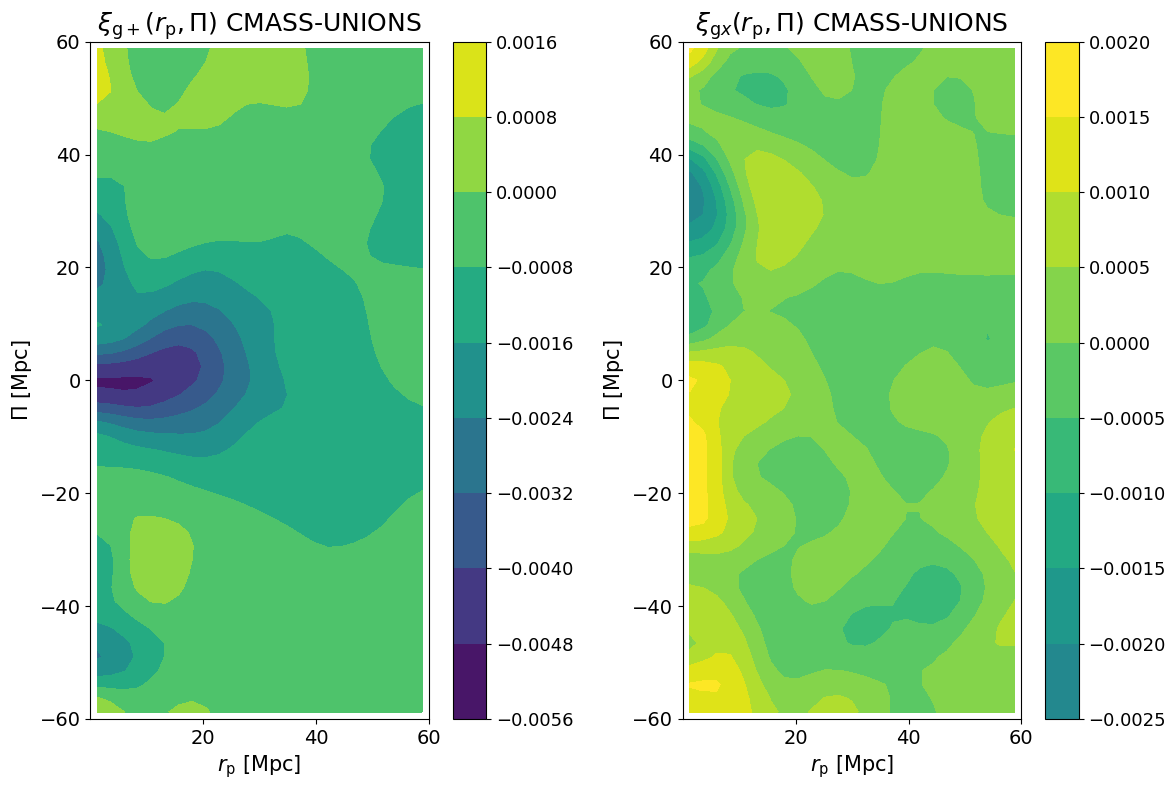

In [42]:
plotting_correlation_function(xi_gp_cmass.T, xi_gc_cmass.T, rmin=60, sigma=2, 
                              contourf=True, vmin=-0.0056, vmax=0.0016, log=False, 
                              title_p=r'$\xi_{{\mathrm{g}}+}(r_{\mathrm{p}},\Pi)$ CMASS-UNIONS', 
                              title_save='CMASS-UNIONS_xi.pdf',
                              title_x=r'$\xi_{{\mathrm{g}}x}(r_{\mathrm{p}},\Pi)$ CMASS-UNIONS')

#### Computing $w_{\mathrm{g+}}$ and $w_{\mathrm{g\times}}$

$w_{\mathrm{g+}}(r_\mathrm{p}) = \int_{-\Pi_{\mathrm{max}}}^{\Pi_{\mathrm{max}}}d\Pi~\xi_{\mathrm{g+}}(r_\mathrm{p},\Pi)$

$w_{\mathrm{g\times}}(r_\mathrm{p}) = \int_{-\Pi_{\mathrm{max}}}^{\Pi_{\mathrm{max}}}d\Pi~\xi_{\mathrm{g\times}}(r_\mathrm{p},\Pi)$

In [48]:
xi_gp_cmass, xi_gc_cmass, var_cmass, r_cmass = compute_galaxy_intrinsic_alignments (x_sd_cmass, y_sd_cmass, z_sd_cmass,
                                             e1_sd_cmass, e2_sd_cmass, 
                                             w_sd_cmass,

                                            x_d_cmass, y_d_cmass, z_d_cmass,

                                            x_r_cmass, y_r_cmass, z_r_cmass,
                                            
                                            nrp=25, npi=50,

                                            pi_max = 20, 
                                         
                                            rp_min=0.1, rp_max = 200.,

                                            npatch=20,
                                            
                                            bin_type='Log')


nrp=25

wgp_cmass = np.zeros(nrp) ; sum_var_gp_cmass=np.zeros(nrp)
wgc_cmass = np.zeros(nrp) ; sum_var_gc_cmass=np.zeros(nrp)

for i in range (nrp):
    wgp_cmass[i] = abs(np.sum(xi_gp_cmass[:,i])) ; sum_var_gp_cmass[i]= np.sum(var_cmass[:,i])
    wgc_cmass[i] = abs(np.sum(xi_gc_cmass[:,i])) ; sum_var_gc_cmass[i]= np.sum(var_cmass[:,i])


sigma_gp_cmass = np.sqrt(sum_var_gp_cmass)
sigma_gc_cmass = np.sqrt(sum_var_gc_cmass)

#### Plotting $r_\mathrm{p} \times w_{\mathrm{g+}}(r_\mathrm{p})$ and $r_\mathrm{p}\times w_{\mathrm{g\times}}(r_\mathrm{p})$

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_39146/1558483192.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


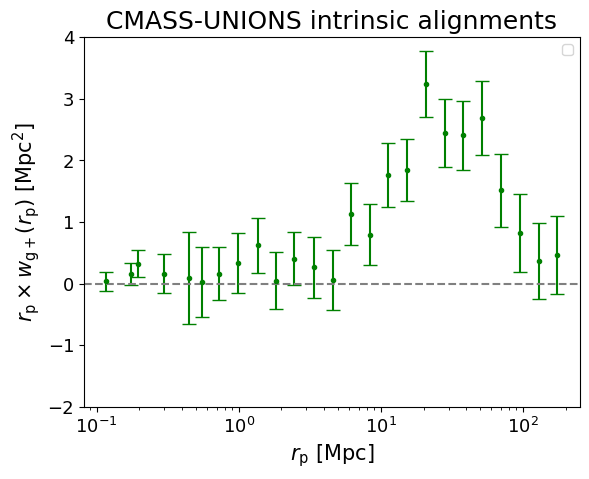

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_39146/1558483192.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


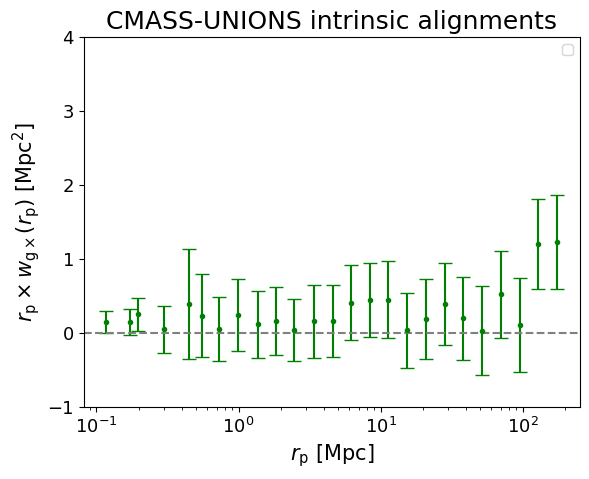

In [ ]:
plt.errorbar(r_cmass[0,:], r_cmass[0,:]*wgp_cmass, yerr= r_cmass[0,:]*sigma_gp_cmass, fmt='o', markersize=3, capsize=5, color='green')
plt.xscale('log')
plt.xlabel(r'$r_{\mathrm{p}}~[\mathrm{Mpc}]$', fontsize=15)
plt.ylabel(r'$r_\mathrm{p} \times w_{\mathrm{g+}}(r_\mathrm{p})~[\mathrm{Mpc}^2]$', fontsize=15) ; plt.ylim(-2,4)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend()
plt.axhline(0, color='grey', linestyle='--')
plt.title("CMASS-UNIONS intrinsic alignments", fontsize=18)
plt.savefig('CMASS-UNIONS_wgp.pdf', bbox_inches='tight')
plt.show()



plt.errorbar(r_cmass[0,:], r_cmass[0,:]*wgc_cmass, yerr= r_cmass[0,:]*sigma_gc_cmass, fmt='o', markersize=3, capsize=5, color='green')
plt.xscale('log')
plt.xlabel(r'$r_{\mathrm{p}}~[\mathrm{Mpc}]$', fontsize=15)
plt.ylabel(r'$r_\mathrm{p} \times w_{\mathrm{g\times}}(r_\mathrm{p})~[\mathrm{Mpc}^2]$', fontsize=15) ; plt.ylim(-2,4)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.ylim(-1,4)
plt.legend()
plt.axhline(0, color='grey', linestyle='--')
plt.title("CMASS-UNIONS intrinsic alignments", fontsize=18)
plt.savefig('CMASS-UNIONS_wgc.pdf', bbox_inches='tight')
plt.show()

### LRG-UNIONS

In [64]:
xi_gp_lrg, xi_gc_lrg, var_lrg, r_lrg = compute_galaxy_intrinsic_alignments (x_sd_lrg, y_sd_lrg, z_sd_lrg,
                                             e1_sd_lrg, e2_sd_lrg, 
                                             w_sd_lrg,

                                            x_d_lrg, y_d_lrg, z_d_lrg,

                                            x_r_lrg, y_r_lrg, z_r_lrg,

                                            pi_max = 60, 
                                         
                                            rp_min=0.1, rp_max = 60.,

                                            bin_type='Linear',
                                            
                                            nrp=25, npi=50,

                                            npatch=20
                                            )

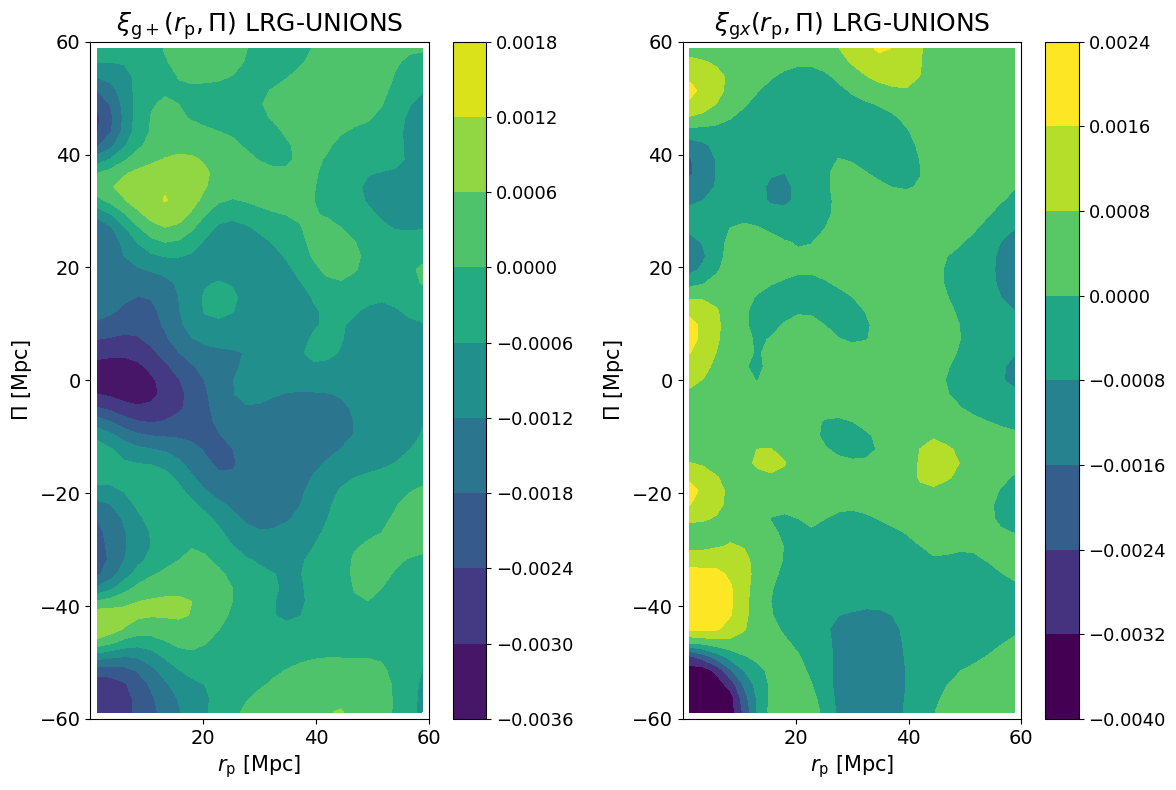

In [67]:
plotting_correlation_function(xi_gp_lrg.T, xi_gc_lrg.T, rmin=60, sigma=2, 
                              contourf=True, vmin=-0.0036, vmax=0.0018, log=False, 
                              title_p=r'$\xi_{{\mathrm{g}}+}(r_{\mathrm{p}},\Pi)$ LRG-UNIONS', 
                              title_save='LRG-UNIONS_xi.pdf',
                              title_x=r'$\xi_{{\mathrm{g}}x}(r_{\mathrm{p}},\Pi)$ LRG-UNIONS')

In [68]:
xi_gp_lrg, xi_gc_lrg, var_lrg, r_lrg = compute_galaxy_intrinsic_alignments (x_sd_lrg, y_sd_lrg, z_sd_lrg,
                                             e1_sd_lrg, e2_sd_lrg, 
                                             w_sd_lrg,

                                            x_d_lrg, y_d_lrg, z_d_lrg,

                                            x_r_lrg, y_r_lrg, z_r_lrg,

                                            pi_max = 20, 
                                         
                                            rp_min=0.1, rp_max = 200.,

                                            bin_type='Log',
                                            
                                            nrp=25, npi=50,

                                            npatch=20
                                            )


nrp=25

wgp_lrg = np.zeros(nrp) ; sum_var_gp_lrg=np.zeros(nrp)
wgc_lrg = np.zeros(nrp) ; sum_var_gc_lrg=np.zeros(nrp)

for i in range (nrp):
    wgp_lrg[i] = abs(np.sum(xi_gp_lrg[:,i])) ; sum_var_gp_lrg[i]= np.sum(var_lrg[:,i])
    wgc_lrg[i] = abs(np.sum(xi_gc_lrg[:,i])) ; sum_var_gc_lrg[i]= np.sum(var_lrg[:,i])


sigma_gp_lrg = np.sqrt(sum_var_gp_lrg)
sigma_gc_lrg = np.sqrt(sum_var_gc_lrg)

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_39146/4062916347.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


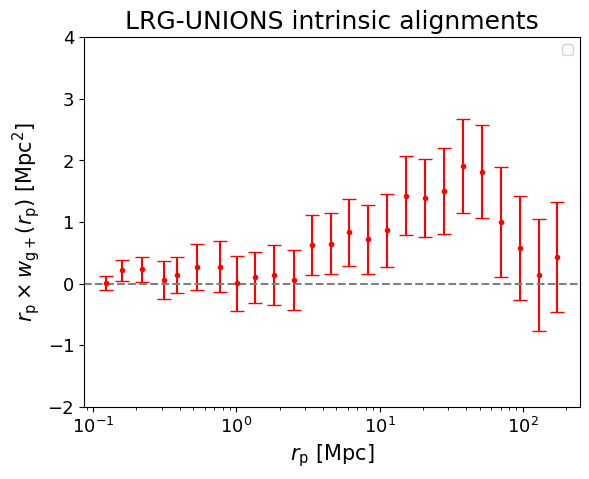

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_39146/4062916347.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


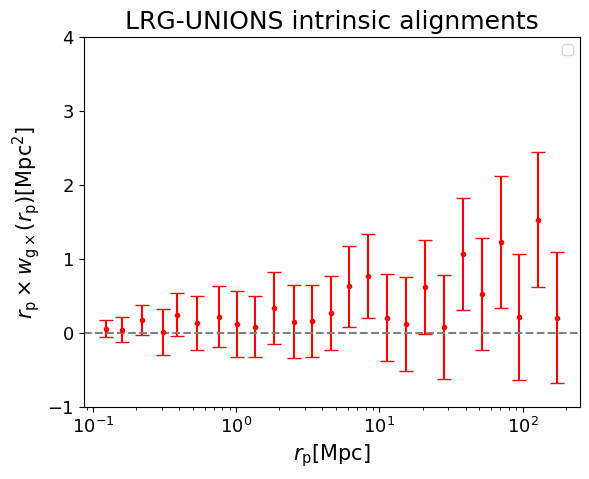

In [69]:
plt.errorbar(r_lrg[0,:], r_lrg[0,:]*wgp_lrg, yerr= r_lrg[0,:]*sigma_gp_lrg, fmt='o', markersize=3, capsize=5, color='red')
plt.xscale('log')
plt.xlabel(r'$r_\mathrm{p}~[\mathrm{Mpc}]$', fontsize=15)
plt.ylabel(r'$r_\mathrm{p} \times w_{\mathrm{g+}}(r_\mathrm{p})~[\mathrm{Mpc}^2]$', fontsize=15) ; plt.ylim(-2,4)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend()
plt.axhline(0, color='grey', linestyle='--')
plt.title("LRG-UNIONS intrinsic alignments", fontsize=18)
plt.savefig("LRG-UNIONS_wgp.pdf", bbox_inches='tight')
plt.show()



plt.errorbar(r_lrg[0,:], r_lrg[0,:]*wgc_lrg, yerr= r_lrg[0,:]*sigma_gc_lrg, fmt='o', markersize=3, capsize=5, color='red')
plt.xscale('log')
plt.xlabel(r'$r_\mathrm{p} [\mathrm{Mpc}]$', fontsize=15)
plt.ylabel(r'$r_\mathrm{p} \times w_{\mathrm{g\times}}(r_\mathrm{p}) [\mathrm{Mpc}^2]$', fontsize=15) ; plt.ylim(-1,4)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.ylim(-1,4)
plt.legend()
plt.axhline(0, color='grey', linestyle='--')
plt.title("LRG-UNIONS intrinsic alignments", fontsize=18)
plt.savefig("LRG-UNIONS_wgc.pdf", bbox_inches='tight')
plt.show()

### ELG-UNIONS

In [79]:
xi_gp_elg, xi_gc_elg, var_elg, r_elg = compute_galaxy_intrinsic_alignments (x_sd_elg, y_sd_elg, z_sd_elg,
                                             e1_sd_elg, e2_sd_elg, 
                                             w_sd_elg,

                                            x_d_elg, y_d_elg, z_d_elg,

                                            x_r_elg, y_r_elg, z_r_elg,

                                            pi_max = 60, 
                                         
                                            rp_min=0.1, rp_max = 60.,

                                            bin_type='Linear',
                                            
                                            nrp=25, npi=50,
                                            
                                            npatch=20)

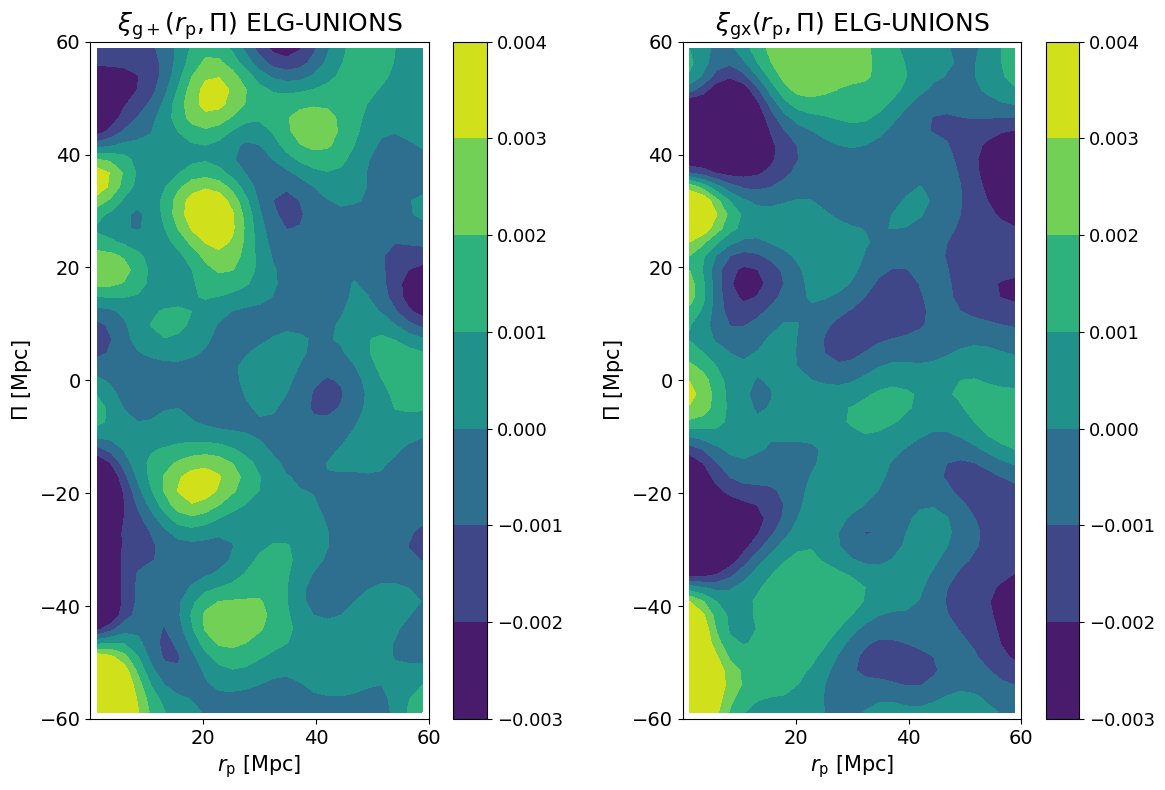

In [81]:
plotting_correlation_function(xi_gp_elg.T, xi_gc_elg.T, rmin=60, sigma=2, 
                              contourf=True, vmin=-0.003, vmax=0.004, log=False, 
                              title_p=r'$\xi_{\mathrm{g+}}(r_\mathrm{p},\Pi)$ ELG-UNIONS', 
                              title_save='ELG-UNIONS_xi.pdf',
                              title_x=r'$\xi_{\mathrm{gx}}(r_\mathrm{p},\Pi)$ ELG-UNIONS')

In [76]:
xi_gp_elg, xi_gc_elg, var_elg, r_elg = compute_galaxy_intrinsic_alignments (x_sd_elg, y_sd_elg, z_sd_elg,
                                             e1_sd_elg, e2_sd_elg, 
                                             w_sd_elg,

                                            x_d_elg, y_d_elg, z_d_elg,

                                            x_r_elg, y_r_elg, z_r_elg,
                                            
                                            pi_max = 60, 
                                         
                                            rp_min=0.1, rp_max = 60.,

                                            bin_type='Log',

                                            nrp=25, npi=50,

                                            npatch=20,
                                            )


nrp=25

wgp_elg = np.zeros(nrp) ; sum_var_gp_elg=np.zeros(nrp)
wgc_elg = np.zeros(nrp) ; sum_var_gc_elg=np.zeros(nrp)

for i in range (nrp):
    wgp_elg[i] = abs(np.sum(xi_gp_elg[:,i])) ; sum_var_gp_elg[i]= np.sum(var_elg[:,i])
    wgc_elg[i] = abs(np.sum(xi_gc_elg[:,i])) ; sum_var_gc_elg[i]= np.sum(var_elg[:,i])


sigma_gp_elg = np.sqrt(sum_var_gp_elg)
sigma_gc_elg = np.sqrt(sum_var_gc_elg)

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_39146/3284236840.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


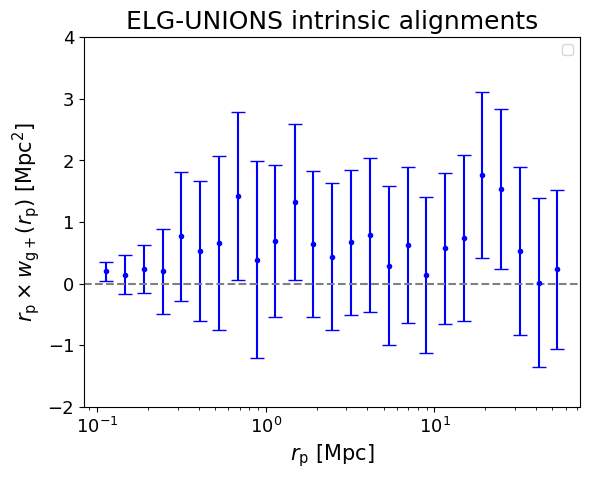

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_39146/3284236840.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


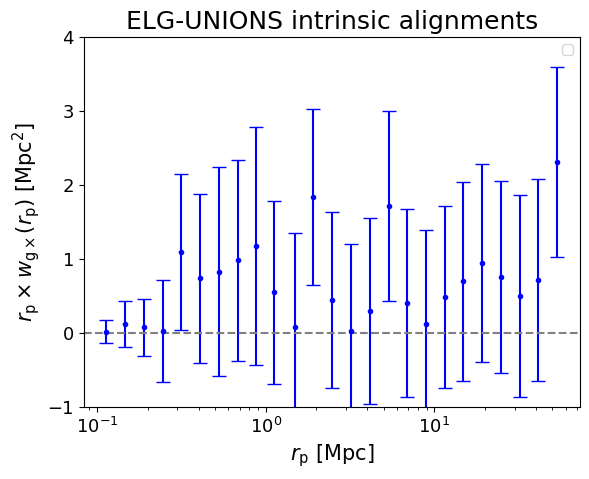

In [78]:
plt.errorbar(r_elg[0,:], r_elg[0,:]*wgp_elg, yerr= r_elg[0,:]*sigma_gp_elg, fmt='o', markersize=3, capsize=5, color='blue')
plt.xscale('log')
plt.xlabel(r'$r_\mathrm{p}~[\mathrm{Mpc}]$', fontsize=15)
plt.ylabel(r'$r_\mathrm{p} \times w_{\mathrm{g+}}(r_\mathrm{p})~[\mathrm{Mpc}^2]$', fontsize=15) ; plt.ylim(-2,4)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend()
plt.axhline(0, color='grey', linestyle='--')
plt.title("ELG-UNIONS intrinsic alignments", fontsize=18)
plt.savefig("ELG-UNIONS_wgp.pdf", bbox_inches='tight')
plt.show()



plt.errorbar(r_elg[0,:], r_elg[0,:]*wgc_elg, yerr= r_elg[0,:]*sigma_gc_elg, fmt='o', markersize=3, capsize=5, color='blue')
plt.xscale('log')
plt.xlabel(r'$r_\mathrm{p}~[\mathrm{Mpc}]$', fontsize=15)
plt.ylabel(r'$r_\mathrm{p} \times w_{\mathrm{g\times}}(r_\mathrm{p})~[\mathrm{Mpc}^2]$', fontsize=15); plt.ylim(-1,4)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.ylim(-1,4)
plt.legend()
plt.axhline(0, color='grey', linestyle='--')
plt.title("ELG-UNIONS intrinsic alignments", fontsize=18)
plt.savefig("ELG-UNIONS_wgc.pdf", bbox_inches='tight')
plt.show()

### BGS-UNIONS

In [20]:
xi_gp_bgs, xi_gc_bgs, var_bgs, r_bgs = compute_galaxy_intrinsic_alignments (x_sd_bgs, y_sd_bgs, z_sd_bgs,
                                             e1_sd_bgs, e2_sd_bgs, 
                                             w_sd_bgs,

                                            x_d_bgs, y_d_bgs, z_d_bgs,

                                            x_r_bgs, y_r_bgs, z_r_bgs,
                                            
                                            pi_max = 60., 
                                         
                                            rp_min=0.1, rp_max = 60.,

                                            bin_type='Linear',
                                            
                                            nrp=25, npi=50,

                                            npatch=20
                                            )

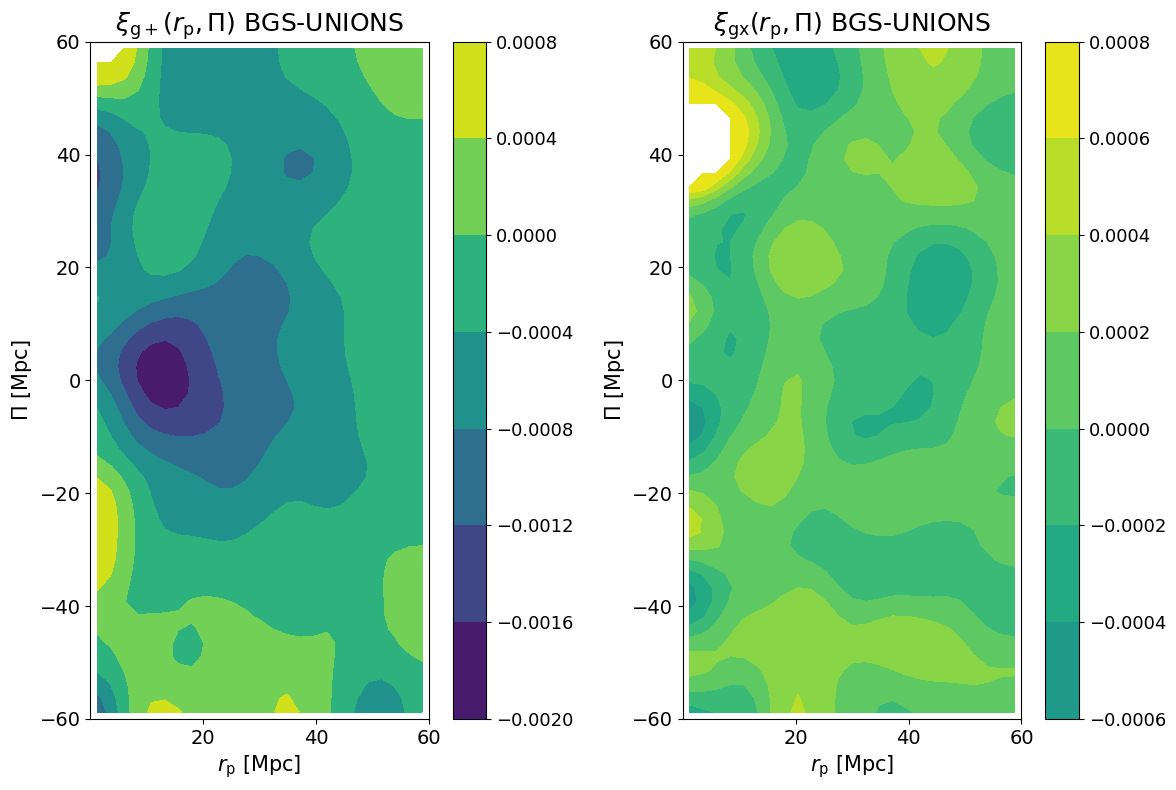

In [21]:
plotting_correlation_function(xi_gp_bgs.T, xi_gc_bgs.T, rmin=60, sigma=2, 
                              contourf=True, vmin=-0.002, vmax=0.0008, log=False, 
                              title_p=r'$\xi_{\mathrm{g+}}(r_\mathrm{p},\Pi)$ BGS-UNIONS', 
                              title_save='BGS-UNIONS_xi.pdf',
                              title_x=r'$\xi_{\mathrm{gx}}(r_\mathrm{p},\Pi)$ BGS-UNIONS')

In [42]:
xi_gp_bgs, xi_gc_bgs, var_bgs, r_bgs = compute_galaxy_intrinsic_alignments (x_sd_bgs, y_sd_bgs, z_sd_bgs,
                                             e1_sd_bgs, e2_sd_bgs, 
                                             w_sd_bgs,

                                            x_d_bgs, y_d_bgs, z_d_bgs,

                                            x_r_bgs, y_r_bgs, z_r_bgs,
                                            
                                            pi_max = 20., 
                                         
                                            rp_min=0.1, rp_max = 200.,

                                            bin_type='Log',
                                            
                                            nrp=25, npi=50,

                                            npatch=20
                                            )


nrp=25

wgp_bgs = np.zeros(nrp) ; sum_var_gp_bgs=np.zeros(nrp)
wgc_bgs = np.zeros(nrp) ; sum_var_gc_bgs=np.zeros(nrp)

for i in range (nrp):
    wgp_bgs[i] = abs(np.sum(xi_gp_bgs[:,i])) ; sum_var_gp_bgs[i]= np.sum(var_bgs[:,i])
    wgc_bgs[i] = abs(np.sum(xi_gc_bgs[:,i])) ; sum_var_gc_bgs[i]= np.sum(var_bgs[:,i])


sigma_gp_bgs = np.sqrt(sum_var_gp_bgs)
sigma_gc_bgs = np.sqrt(sum_var_gc_bgs)

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_72655/1000956372.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


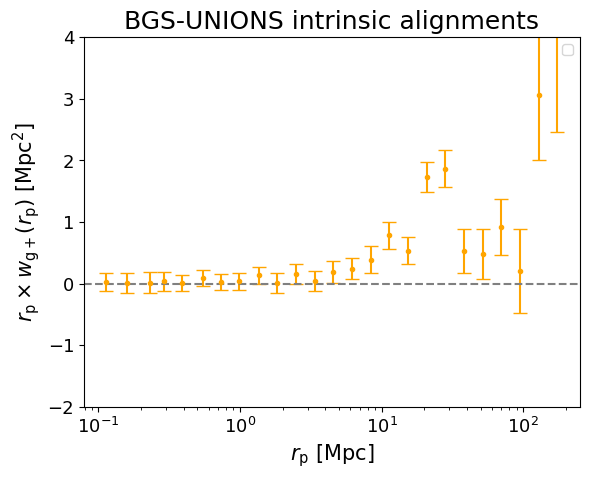

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_72655/1000956372.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


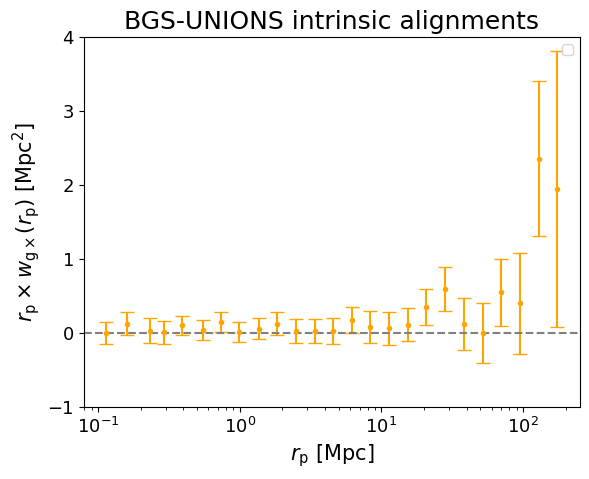

In [43]:
plt.errorbar(r_bgs[0,:], r_bgs[0,:]*wgp_bgs, yerr= r_bgs[0,:]*sigma_gp_bgs, fmt='o', markersize=3, capsize=5, color='orange')
plt.xscale('log')
plt.xlabel(r'$r_\mathrm{p}~[\mathrm{Mpc}]$', fontsize=15)
plt.ylabel(r'$r_\mathrm{p} \times w_{\mathrm{g+}}(r_\mathrm{p})~[\mathrm{Mpc}^2]$', fontsize=15) ; plt.ylim(-2,4)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend()
plt.axhline(0, color='grey', linestyle='--')
plt.title("BGS-UNIONS intrinsic alignments", fontsize=18)
plt.savefig("BGS-UNIONS_wgp.pdf", bbox_inches='tight')
plt.show()



plt.errorbar(r_bgs[0,:], r_bgs[0,:]*wgc_bgs, yerr= r_bgs[0,:]*sigma_gc_bgs, fmt='o', markersize=3, capsize=5, color='orange')
plt.xscale('log')
plt.xlabel(r'$r_\mathrm{p}~[\mathrm{Mpc}]$', fontsize=15)
plt.ylabel(r'$r_\mathrm{p} \times w_{\mathrm{g\times}}(r_\mathrm{p})~[\mathrm{Mpc}^2]$', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.ylim(-1,4)
plt.legend()
plt.axhline(0, color='grey', linestyle='--')
plt.title("BGS-UNIONS intrinsic alignments", fontsize=18)
plt.savefig("BGS-UNIONS_wgc.pdf", bbox_inches='tight')
plt.show()